## Human Protein Multi Label Image Classification 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd, numpy as np
from PIL import Image
from sklearn.metrics import f1_score

import os, gc, time, math, random

In [2]:
# Pytourch modules
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torch.utils.data import Dataset, random_split, DataLoader

## EDA

In [3]:
DATA_DIR = '../input/jovian-pytorch-z2g/Human protein atlas'

TRAIN_DIR = DATA_DIR + '/train'                           # Contains training images
TEST_DIR = DATA_DIR + '/test'                             # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv'                       # Contains real labels for training images
TEST_CSV = '../input/jovian-pytorch-z2g/submission.csv'   # Contains dummy labels for test image

The `train.csv` file contains image IDs and labels for training data. Note that this is a multi-label classification problem. Each image can have more than one type of protein.

In [4]:
!head "{TRAIN_CSV}"

Image,Label
19567,9
29993,6 4
17186,1 4
29600,6 2
701,3 4
26562,9
1080,4
27886,4
30721,6


Similarly, `submission.csv` contains image IDs for test data. However, since the goal of this competition is to make predictions for the test set, the `submission.csv` files contains **dummy labels**, which you need to replace with your predictions and sumbit to the competition on the "Submission" tab. In other words, we don't have the labels for the test set.

In [5]:
!head "{TEST_CSV}"

Image,Label
24117,0
15322,0
14546,0
8079,0
13192,0
25927,0
3372,0
21781,0
2847,0


The image files are named `<image-id>.png` and can be found in the respective `train` and `test` folders.

In [6]:
train_df = pd.read_csv(TRAIN_CSV)
# train_df.head(100)

Let's also put the textual labels in a dictionary for later use.

In [7]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

To create a tensor from the labels, we will encode the labels as vectors of 1s & 0s. For example, if the labels are `'2 4 5'`, the correspoding vector for it would be `[0, 0, 1, 0, 1, 1, 0, 0, 0, 0]`. Let's define helper funtions to encode labels into tensors and vice versa.

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [9]:
SEED = 652
seed_everything(SEED)

In [10]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

def decode_labels(target, thresh=0.5, return_label=False):
    result = []
    for i, tgt in enumerate(target):
        if tgt > thresh:
            if return_label:
                result.append(str(i) + ":" + labels[i] + "/")
            else:
                result.append(str(i))
            
    return result

In [11]:
# decode_target(torch.tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0.]), text_labels=True)

## Creating Datasets & Data Loaders

We can now create a custom dataset by extending the `Dataset` class from PyTorch. We need to define the `__len__` and `__getitem__` methods to create a dataset. We'll also provide the option of adding transforms into the constructor.

In [12]:
class HumanProteinDataset(Dataset):
    def __init__(self, csv_file, root_dir, label_df, transform=None):
        self.df = pd.read_csv(csv_file)
        self.label_df = label_df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

In [13]:
mean = [0.0793, 0.0530, 0.0545]
std = [0.1290, 0.0886, 0.1376]
random_apply = [transforms.ColorJitter(brightness=(0,10), contrast=(10,10), saturation=(10,35), hue=(-.5,.5))]

normalize = transforms.Normalize(mean=mean, std=std, inplace=True)

train_tf = transforms.Compose([
    transforms.RandomCrop(512, padding=4, padding_mode='symmetric'),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
#     transforms.RandomApply(random_apply, p=0.5),
    transforms.ToTensor(),
    normalize,
#     transforms.RandomErasing(inplace=True)
])

test_tf = transforms.Compose([
    transforms.RandomCrop(512, padding=4, padding_mode='symmetric'),
    transforms.ToTensor(),
    normalize
])

Let's check how many samples the dataset contains

In [14]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))

### Training & Validation sets

As a good practice, we should split the data into training and validation datasets. Let's fix a seed for PyTorch (to ensure we always get the same validation set), and create the datasets using `random_split`.

In [15]:
seed_everything(SEED)

I'm using a validation percentage of 10%, but you can use a smaller or larger percentage. One good strategy is to determine a good set of hyperparameters, and then retrain on a smaller validation set for your final submission.

In [16]:
val_pct = 0.1
msk = np.random.rand(len(train_df)) < (1- val_pct)
train_split_df = train_df[msk].reset_index()
val_split_df = train_df[~msk].reset_index()
# val_size = int(val_pct * len(dataset))
# train_size = len(dataset) - val_size

In [17]:
# train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_ds = HumanProteinDataset(TRAIN_CSV, TRAIN_DIR, train_split_df, train_tf)
valid_ds = HumanProteinDataset(TRAIN_CSV, TRAIN_DIR, val_split_df, test_tf)
# len(train_ds), len(val_ds)

Labels: Nucleoli(2) Golgi apparatus(3) Nucleoplasm(4)


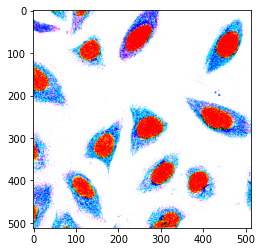

In [18]:
show_sample(*train_ds[66])

### Data Loaders

In [19]:
batch_size = 32

In [20]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(valid_ds, batch_size, num_workers=4, pin_memory=True)

In [21]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

In [22]:
# show_batch(train_dl)

## Model

In [23]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-15))
    recall = torch.mean(TP / (TP + FN + 1e-15))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-15)
    return F2.mean(0)

In [24]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.F1 =[]
        self.its = []
        
    def append(self, loss, F1, it):
        self.losses.append(loss)
        self.F1.append(F1)
        self.its.append(it)

In [25]:
class CLR(object):
    def __init__(self, optim, bn, base_lr=1e-7, max_lr=100):
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.optim = optim
        self.bn = bn - 1
        ratio = self.max_lr/self.base_lr
        self.mult = ratio ** (1/self.bn)
        self.best_loss = 1e9
        self.iteration = 0
        self.lrs = []
        self.losses = []
        
    def calc_lr(self, loss):
        self.iteration +=1
        if math.isnan(loss) or loss > 4 * self.best_loss:
            return -1
        if loss < self.best_loss and self.iteration > 1:
            self.best_loss = loss
            
        mult = self.mult ** self.iteration
        lr = self.base_lr * mult
        
        self.lrs.append(lr)
        self.losses.append(loss)
        
        return lr
        
    def plot(self, start=10, end=-5):
        plt.xlabel("Learning Rate")
        plt.ylabel("Losses")
        plt.plot(self.lrs[start:end], self.losses[start:end])
        plt.xscale('log')
        
        
    def plot_lr(self):
        plt.xlabel("Iterations")
        plt.ylabel("Learning Rate")
        plt.plot(self.lrs)
        plt.yscale('log')

In [26]:
class OneCycle(object):
    def __init__(self, nb, max_lr, momentum_vals=(0.95, 0.85), prcnt= 10, div=10, use_cosine=False):
        self.nb = nb
        self.div = div
        self.high_lr = max_lr
        self.low_mom = momentum_vals[1]
        self.high_mom = momentum_vals[0]
        self.use_cosine = use_cosine
        if self.use_cosine:
            self.prcnt = 0
        else:
            self.prcnt = prcnt
        self.iteration = 0
        self.lrs = []
        self.moms = []
        if self.use_cosine:
            self.step_len =  int(self.nb / 4)
        else:
            self.step_len =  int(self.nb * (1- prcnt/100)/2)
        
    def calc(self):
        if self.use_cosine:
            lr = self.calc_lr_cosine()
            mom = self.calc_mom_cosine()
        else:
            lr = self.calc_lr()
            mom = self.calc_mom()
        self.iteration += 1
        return (lr, mom)
        
    def calc_lr(self):
        if self.iteration ==  0:
            self.lrs.append(self.high_lr/self.div)
            return self.high_lr/self.div
        elif self.iteration == self.nb:
            self.iteration = 0
            self.lrs.append(self.high_lr/self.div)
            return self.high_lr/self.div
        elif self.iteration > 2 * self.step_len:
            ratio = (self.iteration - 2 * self.step_len) / (self.nb - 2 * self.step_len)
#             lr = self.high_lr * ( 1 - 0.99 * ratio)/self.div
            lr = (self.high_lr / self.div) * (1- ratio * (1 - 1/self.div))
        elif self.iteration > self.step_len:
            ratio = 1- (self.iteration -self.step_len)/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        else :
            ratio = self.iteration/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        self.lrs.append(lr)
        return lr

    def calc_mom(self):
        if self.iteration == 0:
            self.moms.append(self.high_mom)
            return self.high_mom
        elif self.iteration == self.nb:
            self.iteration = 0
            self.moms.append(self.high_mom)
            return self.high_mom
        elif self.iteration > 2 * self.step_len:
            mom = self.high_mom
        elif self.iteration > self.step_len:
            ratio = (self.iteration -self.step_len)/self.step_len
            mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
        else :
            ratio = self.iteration/self.step_len
            mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
        self.moms.append(mom)
        return mom

    def calc_lr_cosine(self):
        if self.iteration ==  0:
            self.lrs.append(self.high_lr/self.div)
            return self.high_lr/self.div
        elif self.iteration == self.nb:
            self.iteration = 0
            self.lrs.append(self.high_lr/self.div)
            return self.high_lr/self.div
        elif self.iteration > self.step_len:
            ratio = (self.iteration -self.step_len)/(self.nb - self.step_len)
            lr = (self.high_lr/self.div) + 0.5 * (self.high_lr - self.high_lr/self.div) * (1 + math.cos(math.pi * ratio))
        else :
            ratio = self.iteration/self.step_len
            lr = self.high_lr - 0.5 * (self.high_lr - self.high_lr/self.div) * (1 + math.cos(math.pi * ratio))
        self.lrs.append(lr)
        return lr

    def calc_mom_cosine(self):
        if self.iteration == 0:
            self.moms.append(self.high_mom)
            return self.high_mom
        elif self.iteration == self.nb:
            self.iteration = 0
            self.moms.append(self.high_mom)
            return self.high_mom
        elif self.iteration > self.step_len:
            ratio = (self.iteration -self.step_len)/(self.nb - self.step_len)
            mom = self.high_mom - 0.5 * (self.high_mom - self.low_mom) * (1 + math.cos(math.pi * ratio))
        else :
            ratio = self.iteration/self.step_len
            mom = self.low_mom + 0.5 * (self.high_mom - self.low_mom) * (1 + math.cos(math.pi * ratio))
        self.moms.append(mom)
        return mom

In [27]:
def save_checkpoint(model, is_best, filename='data/checkpoint.pth'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

In [28]:
def load_checkpoint(model, filename = 'data/checkpoint.pth'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()):
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)

In [29]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

In [30]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=1):
        super().__init__()
        self.adavgp = nn.AdaptiveAvgPool2d(sz)
        self.adamaxp = nn.AdaptiveMaxPool2d(sz)
        
    def forward(self, x):
        x = torch.cat([self.adavgp(x), self.adamaxp(x)], 1)
        x = x.view(x.size(0),-1)
        return x

In [31]:
class ProteinCnnModel(nn.Module):
    def __init__(self, in_features, intermed_bn=512, out_features=10, dout=0.25):
        super().__init__()
        self.network = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(256, 32, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(0.1, inplace=True),
#             nn.BatchNorm2d(32),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(32, 256, kernel_size=3, stride=1, padding=1),
#             nn.AdaptiveAvgPool2d(1),

#             nn.Flatten(), 
#             nn.Linear(256, 128),
#             nn.Dropout(0.2),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 10, bias=True),
            
            
            nn.BatchNorm1d(in_features),
            nn.Dropout(dout),
            nn.Linear(in_features, intermed_bn, bias=True),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm1d(intermed_bn, momentum=0.01),
            nn.Dropout(dout),
            nn.Linear(intermed_bn, out_features, bias=True),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.network(x)

In [32]:
class ProteinCnnModel3(nn.Module):
    def __init__(self, dout=0.25):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 256, kernel_size=3, stride=1, padding=1),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(), 
#             nn.Linear(256, 128),
#             nn.Dropout(0.2),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 10, bias=True),
            
            
            nn.BatchNorm1d(256),
            nn.Dropout(dout),
            nn.Linear(256, 128, bias=True),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm1d(128, momentum=0.01),
            nn.Dropout(dout),
            nn.Linear(128, 64, bias=True),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.network(x)

In [33]:
# class ProteinCnnModel2(MultilabelImageClassificationBase):
#     def __init__(self):
#         super().__init__()
#         # Use a pretrained model
#         self.network = models.resnet34(pretrained=True)
#         # Replace last layer
#         num_ftrs = self.network.fc.in_features
#         self.network.fc = nn.Linear(num_ftrs, 10)
    
#     def forward(self, xb):
#         return torch.sigmoid(self.network(xb))

In [34]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr
    
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom
        
def find_lr(model, loader, device):
    t = tqdm(loader, leave=False, total=len(loader))
    running_loss = 0.
    avg_beta = 0.98
    model.train()
    for i, (ip, tgt) in enumerate(t):
        ip, tgt = ip.to(device), tgt.to(device)
        output = torch.sigmoid(model(ip))
        loss = criterion(output, tgt)

        running_loss = avg_beta * running_loss + (1-avg_beta) *loss.item()
        smoothed_loss = running_loss / (1 - avg_beta**(i+1))
        t.set_postfix(loss=smoothed_loss)

        lr = clr.calc_lr(smoothed_loss)
        if lr == -1 :
            break
        update_lr(optimizer, lr)   

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [35]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [36]:
# model = models.resnet34(pretrained=True)
model = ProteinCnnModel3()
model

ProteinCnnModel3(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.1, inplace=True)
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12):

In [37]:
# model.avgpool = AdaptiveConcatPool2d()
# model.fc = ProteinCnnModel(in_features=model.fc.in_features*2, out_features=10)

In [38]:
device = get_default_device()
device

device(type='cuda')

In [39]:
for param in model.parameters():
    param.require_grad = True
    
model = model.to(device)

In [40]:
# model

In [41]:
gc.collect()

2452

In [42]:
criterion = nn.BCELoss()

In [43]:
train_loader = DeviceDataLoader(train_dl, device)
valid_loader = DeviceDataLoader(val_dl, device)
model = to_device(model, device)

In [44]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

# try_batch(train_dl)

If your kernel runs out of memory here, you might need to reduce your batch size.

## Training the model

In [45]:
from tqdm.notebook import tqdm

In [46]:
gc.collect()

100

In [47]:
save_checkpoint(model, True, 'init.pth')

In [48]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
clr = CLR(optimizer, len(train_loader))

In [49]:
find_lr(model, train_loader, device)

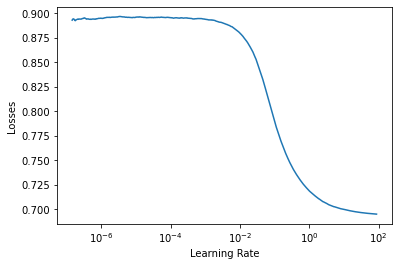

In [50]:
clr.plot()

In [51]:
bs = batch_size

In [52]:
train_stats = AvgStats()
test_stats = AvgStats()
best_F1 = 0
trn_time = 0
trn_losses = 0.0
trn_F1 = 0.0
val_losses = 0.0
val_F1 = 0.0
val_time = 0

In [53]:
def train(epoch, model, optimizer, use_cycle=False, onecycle=None):
    model.train()
    global trn_F1, trn_losses, trn_time
    running_loss = 0.
    running_F1 = 0.
    
    start_time = time.time()
    
    t = tqdm(train_loader, leave=False, total=len(train_loader))

    for i, (ip, tgt) in enumerate(t):
        ip, tgt = ip.to(device), tgt.to(device)
        
        if use_cycle:    
            lr, mom = onecycle.calc()
            update_lr(optimizer, lr)
            update_mom(optimizer, mom)
                                    
#         output = torch.sigmoid(model(ip))
        output = model(ip)
        loss = criterion(output, tgt)
        running_loss += loss.item()
            
        # Append outputs
        running_F1 += F_score(tgt, output)
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    trn_time = time.time() - start_time        
    trn_F1 = running_F1/len(train_loader)
    trn_losses = running_loss/len(train_loader)

In [54]:
def test(model):
    with torch.no_grad():
        model.eval()
        global best_F1
        global val_F1, val_losses, val_time
        running_loss = 0.
        running_F1 = 0.
        start_time = time.time()
        
        t = tqdm(valid_loader, leave=False, total=len(valid_loader))
        
        for i, (ip, tgt) in enumerate(t):
            ip, tgt = ip.to(device), tgt.to(device)
#             output = torch.sigmoid(model(ip))
            output = model(ip)
            loss = criterion(output, tgt)
            running_loss += loss.item()
            running_F1 += F_score(tgt, output)
            
        val_time = time.time() - start_time
        F1_score = running_F1/len(valid_loader)
        if F1_score > best_F1:
            best_F1 = F1_score
            save_checkpoint(model, True, './best_model.pth')
            
        val_F1 = F1_score
        val_losses = running_loss/len(valid_loader)

In [55]:
def fit(model, optimizer, epochs, sched=None, use_cycle=False, onecycle=None):
    print("Epoch\tTrn_loss\tVal_loss\tTrn_F1\t\tVal_F1")
    for j in range(epochs):
        train(j, model, optimizer, use_cycle=use_cycle, onecycle=onecycle)
        train_stats.append(trn_losses, trn_F1, trn_time)
        test(model)
        test_stats.append(val_losses, val_F1, val_time)
        if sched:
            sched.step(j)
        print("{}\t{:06.8f}\t{:06.8f}\t{:06.8f}\t{:06.8f}"
              .format(j+1, trn_losses, val_losses, trn_F1, val_F1))

In [56]:
epochs = 20
load_checkpoint(model, 'init.pth')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
ocp = OneCycle(int(len(train_ds) * epochs /bs), 1e-1, use_cosine=True)
# sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [57]:
fit(model, optimizer, epochs, use_cycle=True, onecycle=ocp)

Epoch	Trn_loss	Val_loss	Trn_F1		Val_F1


1	0.35492902	0.31808623	0.31158835	0.37505558


2	0.31372855	0.31577706	0.39268458	0.40984160


3	0.29899924	0.33361844	0.44364250	0.28462189


4	0.28623371	0.30170640	0.47668648	0.51521784


5	0.27773277	0.27723283	0.50511891	0.50234801


6	0.26919581	0.26912522	0.53113753	0.47538325


7	0.26326328	0.30137423	0.55035627	0.47516796


15	0.22998704	0.22108773	0.64747351	0.66563267


16	0.22742822	0.22560802	0.64946771	0.65809321


17	0.22313991	0.21676580	0.65858686	0.67922086


20	0.21407064	0.20585716	0.68317825	0.66669923


In [58]:
# num_epochs = 50
# lr = 1e-5

# @torch.no_grad()
# def evaluate(model, val_loader):
#     model.eval()
#     outputs = [model.validation_step(batch) for batch in val_loader]
#     return model.validation_epoch_end(outputs)

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
#     torch.cuda.empty_cache()
#     history = []
#     optimizer = opt_func(model.parameters(), lr)
#     for epoch in range(epochs):
#         # Training Phase 
#         model.train()
#         train_losses = []
#         for batch in tqdm(train_loader):
#             loss = model.training_step(batch)
#             train_losses.append(loss)
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
#         # Validation phase
#         result = evaluate(model, val_loader)
#         result['train_loss'] = torch.stack(train_losses).mean().item()
#         model.epoch_end(epoch, result)
#         history.append(result)
#     return history

In [59]:
# evaluate(model, val_dl)

In [60]:
gc.collect()

4142

In [61]:
# history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [62]:
# gc.collect()

## Making predictions & submission

To start with, let's create a helper function to make a prediction on a single image.

In [63]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

Next, let's create a test dataset using the `submission.csv` file. Note that the file contains dummy labels (always `'0'`). We'll use the same transforms we used for the training set.

In [64]:
test_df = pd.read_csv(TEST_CSV)
# test_dataset = HumanProteinDataset(TEST_CSV, TEST_DIR, transform=transform)
test_dataset = HumanProteinDataset(TEST_CSV, TEST_DIR, test_df, test_tf)

In [65]:
# img, target = test_dataset[3]
# img.shape

Let's try predicting the labels for some sample images

In [66]:
# predict_single(test_dataset[100][0])

In [67]:
# predict_single(test_dataset[74][0])

## Creating a submission file

In [68]:
gc.collect()

160

In [69]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=4, pin_memory=True), device)

In [70]:
load_checkpoint(model, './best_model.pth')

In [71]:
def predict(loader):
    with torch.no_grad():
        torch.cuda.empty_cache()
        model.eval()
        preds = []
        t = tqdm(loader, leave=False, total=len(loader))
        for i, (ip, _) in enumerate(t):
            ip = ip.to(device)
#             output = torch.sigmoid(model(ip))
            output = model(ip)
            preds.append(output.cpu().detach())
        preds = torch.cat(preds)
        return [" ".join(decode_labels(pred)) for pred in preds]

In [72]:
# @torch.no_grad()
# def predict_dl(dl, model):
#     torch.cuda.empty_cache()
#     batch_probs = []
#     for xb, _ in tqdm(dl):
#         probs = model(xb)
#         batch_probs.append(probs.cpu().detach())
#     batch_probs = torch.cat(batch_probs)
#     return [decode_target(x) for x in batch_probs]

In [73]:
# test_preds = predict_dl(test_dl, model)
preds = predict(test_loader)

Let us know create a submission file with these predictions

In [74]:
submission_df = pd.read_csv(TEST_CSV)
submission_df.Label = preds
submission_df.tail(100)

,Image,Label
8143,17482,2 4
8144,819,4 6
8145,1577,4
8146,12332,5
8147,15379,6
...,...,...
8238,2982,0
8239,17414,2 4
8240,20223,0
8241,12031,2


We can now save it batck to CSV, and download the file from the sidebar (check the output folder)

In [75]:
sub_fname = 'submission.csv'

In [76]:
submission_df.to_csv(sub_fname, index=False)

You can now upload this submission file here: https://www.kaggle.com/c/jovian-pytorch-z2g/submit

## Save to Jovian

In [77]:
!pip install jovian --upgrade

     |████████████████████████████████| 63 kB 1.1 MB/s 
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6500 sha256=ad2079d60087ae053cc12d1be35a6ae38790a55a8403eb01d9470451d8d9cd55
  Stored in directory: /root/.cache/pip/wheels/2a/ea/87/dd57f1ecb4f0752f3e1dbf958ebf8b36d920d190425bcdc24d
Successfully built uuid


In [78]:
import jovian

<IPython.core.display.Javascript object>

In [79]:
jovian.commit(project='zerogans-protein-competition')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..


[jovian] Error: Failed to detect notebook filename. Please provide the correct notebook filename as the "filename" argument to "jovian.commit".


You can also use the "Save Version" button on Kaggle itself, to save a copy on your Kaggle profile.